# 残差分析

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st

## 0.建模前的数据考察
* 需要考察每个单变量的分布状况，对其有一个总的认识
* 数据是否偏斜、是否有异常值（有：异常值的原因，是否需要删除该异常值）
* 对多维图进行两两组对的二维图
### 0.1 直方图

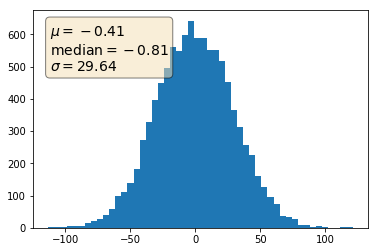

In [2]:
np.random.seed(19680801)

fig, ax = plt.subplots()
x = 30*np.random.randn(10000)
mu = x.mean()
median = np.median(x)
sigma = x.std()
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))

ax.hist(x, 50)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

### 0.2 箱线图

/Users/luofeifei/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


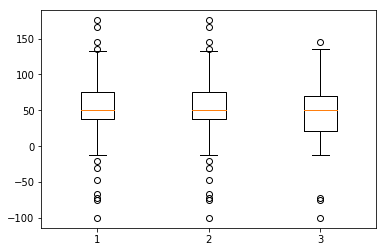

In [3]:
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low))
d2 = np.concatenate((spread, center, flier_high, flier_low))
# Making a 2-D array only works if all the columns are the
# same length.  If they are not, then use a list instead.
# This is actually more efficient because boxplot converts
# a 2-D array into a list of vectors internally anyway.
data = [data, d2, d2[::2]]
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)

plt.show()

### 0.3 二维图

In [5]:
data = pd.read_csv("/Users/luofeifei/study/RegressionAnalysis/All_Data/P103.txt",sep="\t")

In [6]:
import seaborn as sns

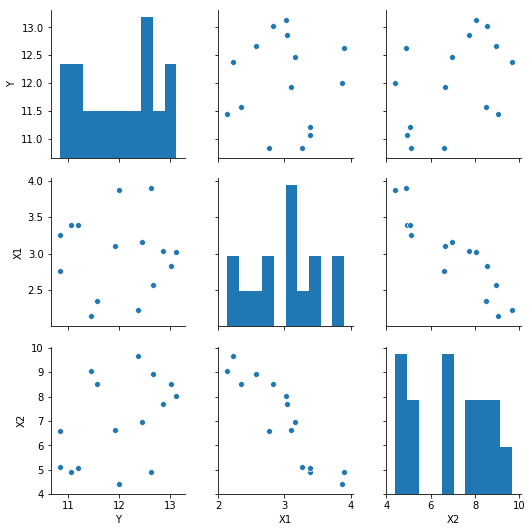

In [7]:
sns.pairplot(data,kind="scatter")
plt.show()

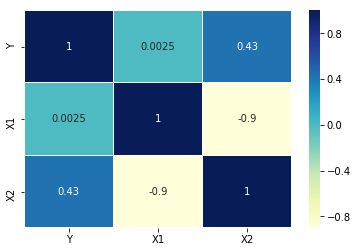

In [8]:
sns.heatmap(data.corr(),linewidths=0.2, cmap="YlGnBu",annot=True)

### 0.4 三维图

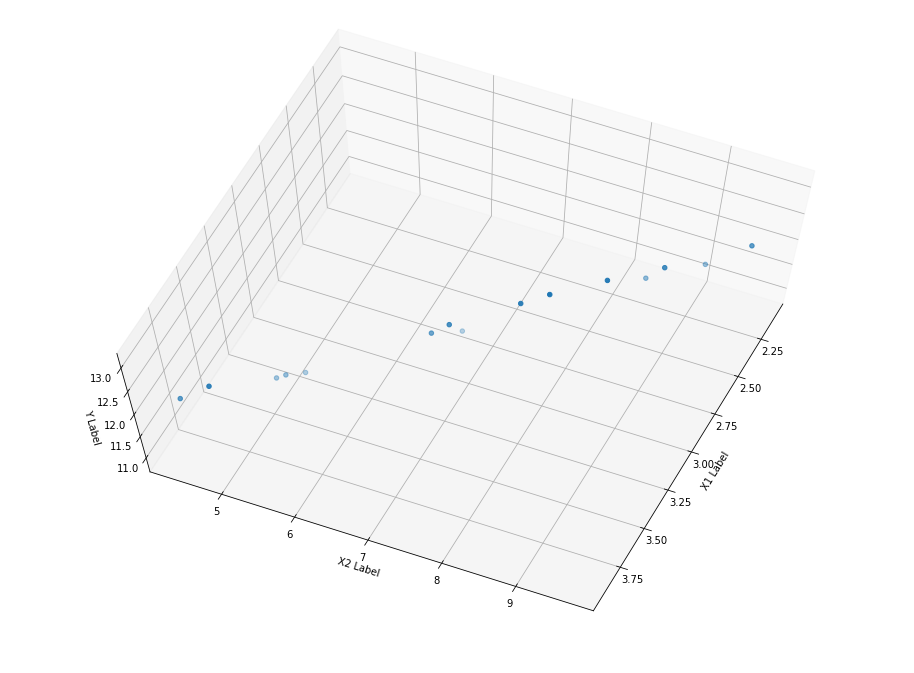

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 12))  #参数为图片大小
ax = fig.gca(projection='3d') 
ax.scatter(data["X1"],data["X2"],data["Y"])
ax.set_xlabel('X1 Label')
ax.set_ylabel('X2 Label')
ax.set_zlabel('Y Label')
ax.view_init(70, 24)

## 1.强影响点
* 要么是X异常，要么是Y异常，Y异常通过考察标准化残差图一般就能看得出来

In [46]:
river_data = pd.read_csv("/Users/luofeifei/study/RegressionAnalysis/All_Data/P010.txt",sep="\t")
river_data.set_index("River",inplace=True,drop=True)

In [47]:
def get_pii(river_data):
    X_C = sm.add_constant(river_data)
    XX_T = np.dot(X_C.values.T,X_C.values)
    left = np.dot(X_C,(np.linalg.inv(XX_T)))
    P = np.dot(left,X_C.T)
    pii = []
    for i in range(P.shape[0]):
        pii.append(P[i][i])
    return pii

In [48]:
pii = get_pii(river_data["ComIndl"])

In [49]:
river_model = smf.ols("Nitrogen~ComIndl",river_data).fit()

In [50]:
print(river_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Nitrogen   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     7.124
Date:                Mon, 14 Sep 2020   Prob (F-statistic):             0.0156
Time:                        23:05:50   Log-Likelihood:                -7.9589
No. Observations:                  20   AIC:                             19.92
Df Residuals:                      18   BIC:                             21.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9988      0.104      9.636      0.0

In [51]:
sigma_hat = np.sqrt(sum(river_model.resid.values**2)/river_model.df_resid)

In [52]:
standard_error = river_model.resid.values/(sigma_hat*np.sqrt(1-np.array(pii)))

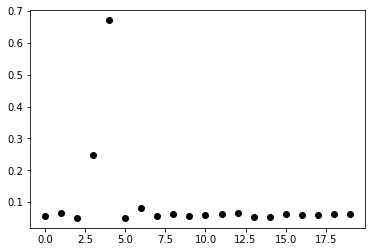

In [53]:
plt.plot(pii,'ko')

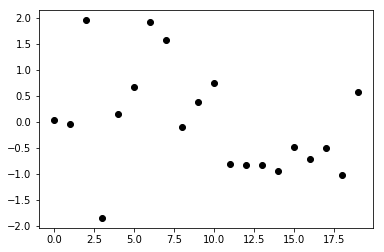

In [54]:
fig, ax = plt.subplots()
plt.plot(standard_error,'ko')
#ax.set_xticklabels(river_data.index.values)
plt.show()

### 回归线与散点图

In [ ]:
fig, ax = plt.subplots()
plt.plot(river_data.ComIndl.values,river_data.Nitrogen.values,"ko")
parameter = np.polyfit(river_data.ComIndl.values,river_data.Nitrogen.values, 1)
f = np.poly1d(parameter)
plt.plot(river_data.ComIndl.values,f(river_data.ComIndl.values),"b--")
ax.set_xlabel("ComIndl")
ax.set_ylabel("Nitrogen")
plt.show()

### Cook距离

In [ ]:
#Cook距离
Ci = (standard_error**2/2)*np.array(pii)/(1-np.array(pii))

In [ ]:
fig, ax = plt.subplots()
plt.plot(Ci,'ko')
plt.show()

### Hadi度量

In [ ]:
#Hadi度量
di = river_model.resid.values/np.sqrt(sum(river_model.resid.values**2))
Hi = np.array(pii)/(1-np.array(pii)) + 2/(1-np.array(pii))*(di**2)/(1-di**2)

In [ ]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)
Hi

In [ ]:
fig, ax = plt.subplots()
plt.plot(Hi,'ko')
plt.show()

### L-R，位势-残差图

In [ ]:
#L-R
L = np.array(pii)/(1-np.array(pii))
R = 2/(1-np.array(pii))*(di**2)/(1-di**2)

In [ ]:
fig, ax = plt.subplots()
plt.plot(R,L,'ko')
plt.show()

# 2.变量作用

In [ ]:
Climb_data = pd.read_csv("/Users/luofeifei/study/DataAnalysis/All_Data/P120.txt",sep="  \t",engine='python')
Climb_data.set_index("Hill Race",inplace=True,drop=True)

In [ ]:
Climb_model = smf.ols("Time~Distance+Climb",data=Climb_data).fit()
print(Climb_model.summary())

### 残差加分量图

In [ ]:
re_X = Climb_model.resid.values + Climb_model.params.Distance*Climb_data.Distance.values

In [ ]:
fig, ax = plt.subplots()
plt.plot(Climb_data.Distance.values,re_X,'ko')
plt.show()